In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

In [ ]:
train_df = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
print(train_df.shape)
train_df.head()

(3662, 2)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [ ]:
train_dir = "../input/aptos2019-blindness-detection/train_images"
train_df['image_path'] = train_df['id_code'].map(lambda x: '{}.png'.format(x))
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df.head()

id_code diagnosis        image_path
0  000c1434d8d7         2  000c1434d8d7.png
1  001639a390f0         4  001639a390f0.png
2  0024cdab0c1e         1  0024cdab0c1e.png
3  002c21358ce6         0  002c21358ce6.png
4  005b95c28852         0  005b95c28852.png

In [ ]:
test_df = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
print(test_df.shape)
test_df.head()

(1928, 1)


id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [ ]:
test_dir = "../input/aptos2019-blindness-detection/test_images"
test_df['image_path'] = test_df['id_code'].map(lambda x: '{}.png'.format(x))
test_df.head()

id_code        image_path
0  0005cfc8afb6  0005cfc8afb6.png
1  003f0afdcd15  003f0afdcd15.png
2  006efc72b638  006efc72b638.png
3  00836aaacf06  00836aaacf06.png
4  009245722fa4  009245722fa4.png

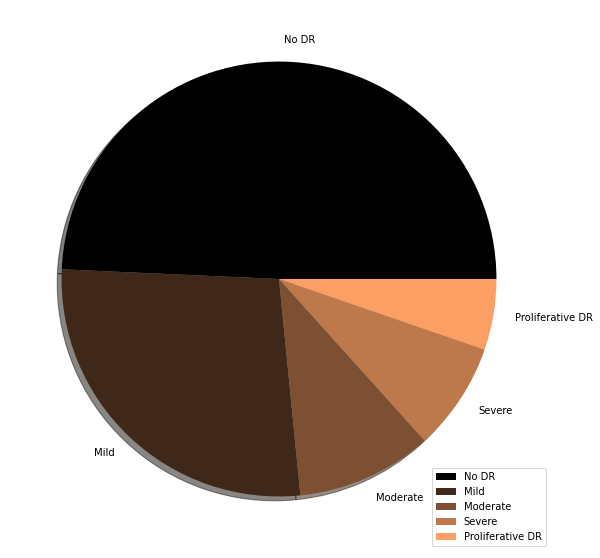

<Figure size 720x720 with 0 Axes>

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
theme = plt.get_cmap('copper')
ax1.set_prop_cycle("color", [theme(1. * i / 5) for i in range(5)])
plt.figure(figsize=(10,10))
ax1.pie(train_df.diagnosis.value_counts(), labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"], shadow=True)
ax1.legend()
plt.show()

Before we visualize the eye scans, it is important for us to understand the difference between normal eye scan and defective eye scan (i.e. with diabetic retinopathy). I did a little research on internet and came across some really interesting info-graphics for the same.

![](https://www.eye7.in/wp-content/uploads/illustration-showing-diabetic-retinopathy.jpg)
<center><small>Source: eye7.in</small></center>

![](https://blog.intelec.ai/images/dr/dr_explanation.png)
<center><small>Source: intelec.ai</small></center>

Hence, we can conclude that there is class imbalance in this dataset.

In [ ]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (150,150))
    return img

def visualize_imgs(df, sample_cnt, color_scale=None):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(sample_cnt))
    df = df.reset_index(drop = True)
    
    for pt in range(sample_cnt):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Fundus Eye Scans")  
        temp = df[df.index.isin([pt + (sample_cnt*0),pt + (sample_cnt*1), pt + (sample_cnt*2),pt + (sample_cnt*3),pt + (sample_cnt*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(os.path.join(train_dir, temp.image_path.iloc[i])))
                axarr[i].set_axis_off()
                axarr[i].imshow(img,cmap = color_scale)
            elif color_scale == 'colormap':
                img = conv_gray(cv2.imread(os.path.join(train_dir, temp.image_path.iloc[i])))
                axarr[i].set_axis_off()
                axarr[i].imshow(img, cmap="viridis")
            else:
                axarr[i].set_axis_off()
                axarr[i].imshow(Image.open(os.path.join(train_dir, temp.image_path.iloc[i])).resize((150,150)))
            axarr[i].set_xlabel('Class '+str(temp.diagnosis.iloc[i]))
        plt.show()

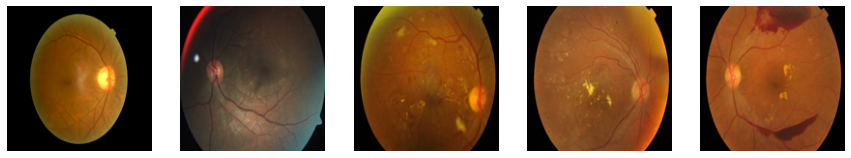

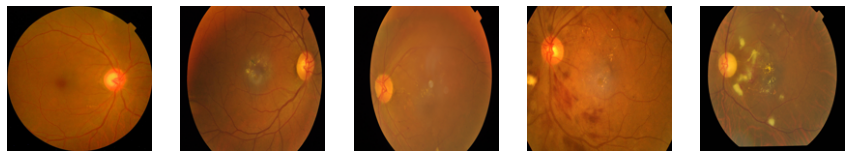

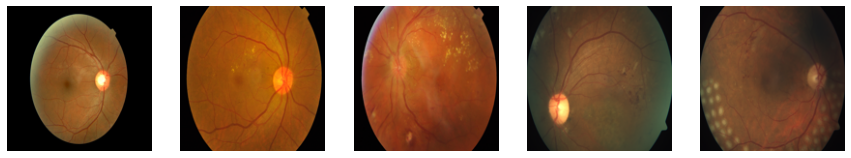

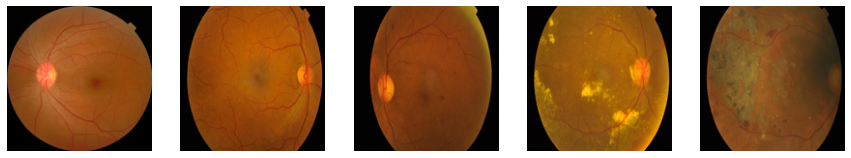

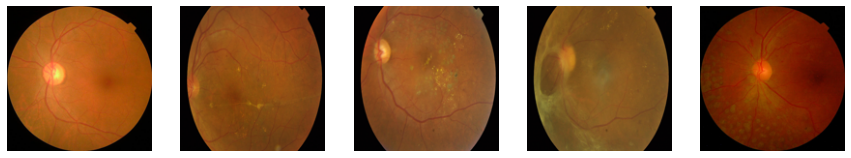

In [ ]:
visualize_imgs(train_df, 5)

In the above images, we can see there is a lot of need for processing. Some of the major problems that we may see with the above scans are:
1. Varying brightness of the scans
2. Noise such as the extra black background
3. Varying sizes of the eye scans

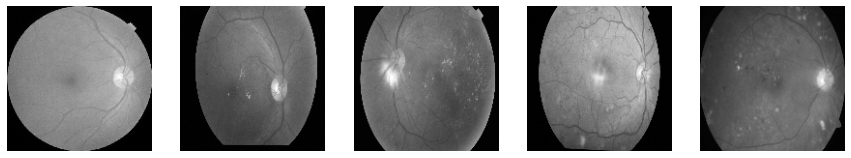

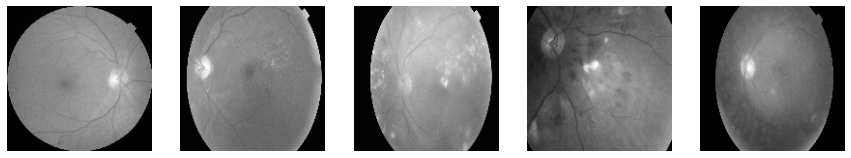

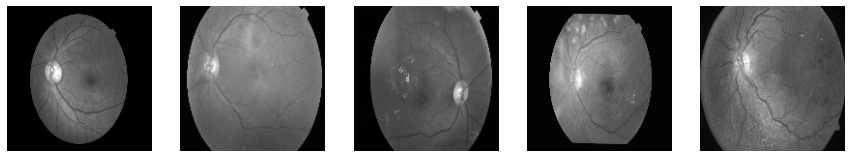

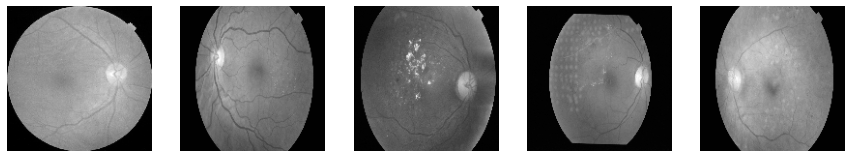

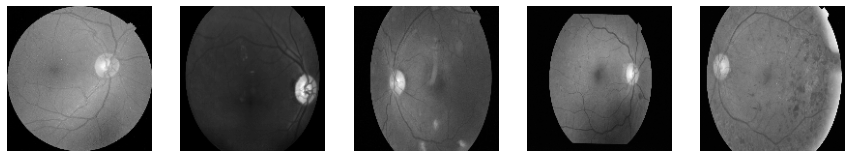

In [ ]:
visualize_imgs(train_df, 5, 'gray')

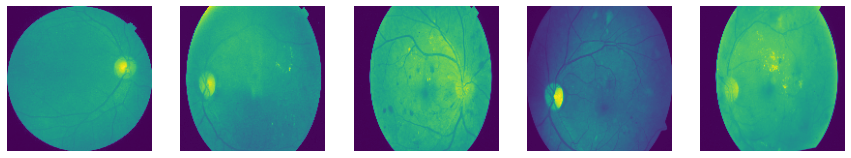

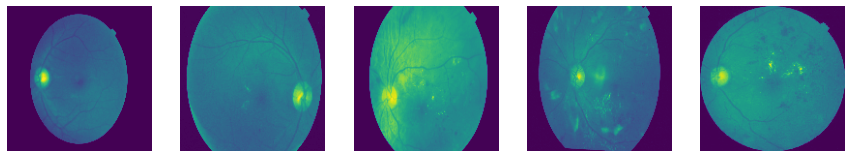

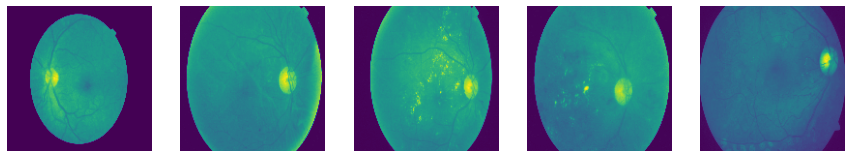

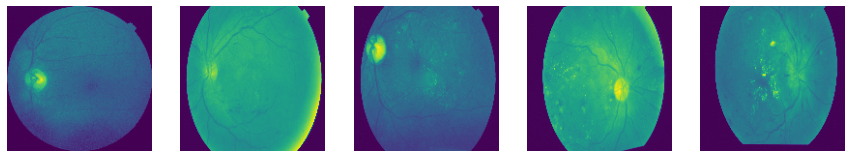

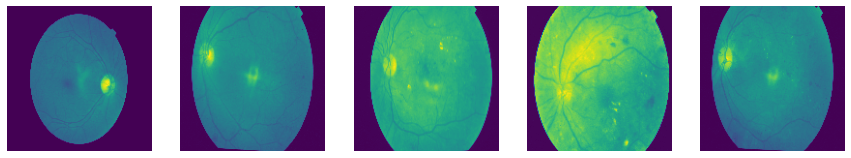

In [ ]:
visualize_imgs(train_df, 5, 'colormap')

In grayscale version, we are able to see the irregularities in the scans with eye defects more clearly. To be specific, we can identify the "exudates" and "hemorrhages" in eye scans with proliferative and severe DR.

"anuerysms" are also visible quite clearly in some scans of defective eyes. 

### Image Preprocessing

In next few cells, we will be applying some processing on the image using OpenCV to clean the scans and fix the irregularities that we noted above.

1. Averaging

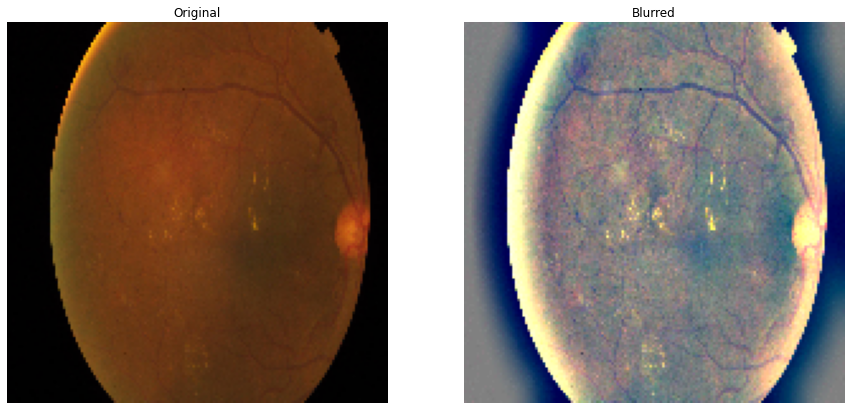

In [ ]:
img = cv2.imread('../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (150,150))
# blur = cv2.blur(img,(20,20))
blur = cv2.addWeighted(img,4, cv2.blur(img,(30,30)), -4 ,128)
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.axis('off')
plt.show()

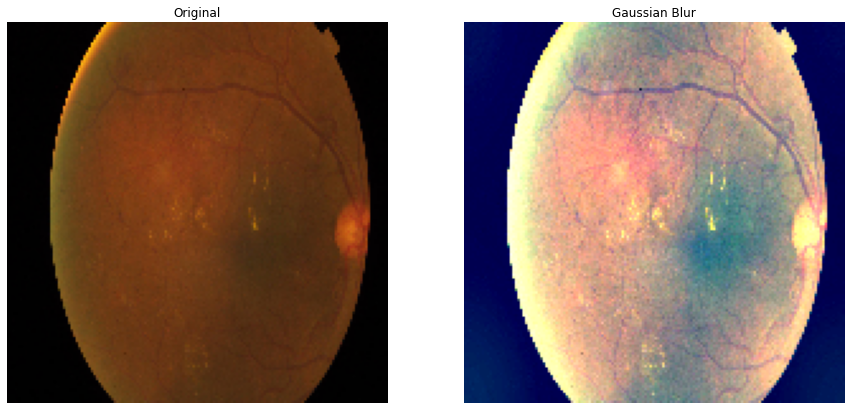

In [ ]:
img = cv2.imread('../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (150,150))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(img_t),plt.title('Gaussian Blur')
plt.axis('off')
plt.show()

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [ ]:
def circle_crop(img, sigmaX=30):   
    """
    Create circular crop around image centre    
    """
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img_t =cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img_t, img 

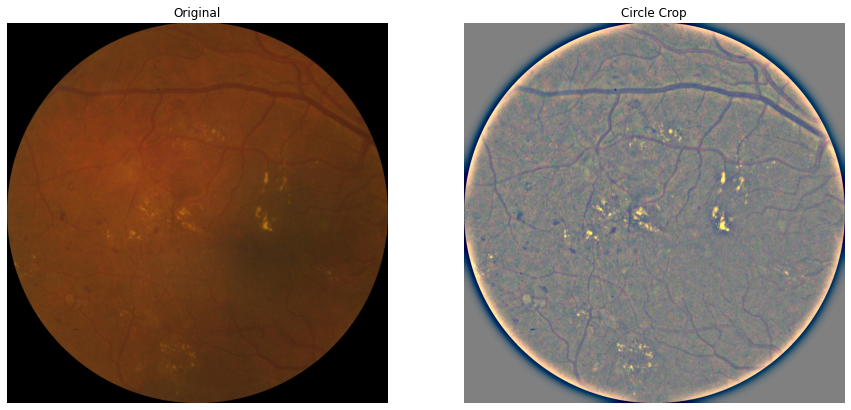

In [ ]:
img, original = circle_crop("../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png")
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(original),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(img),plt.title('Circle Crop')
plt.axis('off')
plt.show()

In [ ]:
train_dir = "../input/aptos2019-blindness-detection/train_images"
for img_name in tqdm(os.listdir(train_dir), total=len(os.listdir(train_dir))):
    img_path = os.path.join(train_dir, img_name)
    img = cv2.imread(img_path)
    cv2.imwrite(img_path, cv2.resize(img, (512,512)))

100%|██████████| 3662/3662 [08:03<00:00,  7.57it/s]


In [ ]:
test_dir = "../input/aptos2019-blindness-detection/test_images"
for img_name in tqdm(os.listdir(test_dir), total=len(os.listdir(test_dir))):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path)
    cv2.imwrite(img_path, cv2.resize(img, (512,512)))

100%|██████████| 1928/1928 [01:29<00:00, 21.43it/s]


In [ ]:
train_dir = "../input/aptos2019-blindness-detection/train_images"
for img_name in tqdm(os.listdir(train_dir), total=len(os.listdir(train_dir))):
    img_path = os.path.join(train_dir, img_name)
    img_pr, _ = circle_crop(img_path)
    cv2.imwrite(img_path, cv2.resize(img_pr, (512,512)))

100%|██████████| 3662/3662 [55:06<00:00,  1.11it/s]


In [ ]:
test_dir = "../input/aptos2019-blindness-detection/test_images"
for img_name in tqdm(os.listdir(test_dir), total=len(os.listdir(test_dir))):
    img_path = os.path.join(test_dir, img_name)
    img_pr, _ = circle_crop(img_path)
    cv2.imwrite(img_path, cv2.resize(img_pr, (512,512)))

100%|██████████| 1928/1928 [13:23<00:00,  2.40it/s]


###Modeling

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization

In [ ]:
BATCH_SIZE = 4
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
IMG_DIM = 320

####Creating training and validation dataset loaders using ImageDataGenerators of Tensorflow

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.15, 
                                    horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="image_path",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shuffle=True
                                                    )

Found 3113 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="image_path",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shuffle=True,
                                                    )

Found 549 validated image filenames belonging to 5 classes.


####Downloading the "efficientnet" library to load the model

In [ ]:
# !pip install -U '../input/install/efficientnet-0.0.3-py2.py3-none-any.whl'
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 522 kB/s 


In [ ]:
from efficientnet.keras import EfficientNetB5

input_tensor = Input(shape=(320, 320, 3))
base_model = EfficientNetB5(weights=None, input_tensor=input_tensor, include_top=False)
base_model.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5")

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation=elu)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation=elu)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=elu)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax', name="Output_Layer")(x)
model_eff = Model(input_tensor, output_layer)

Freezing the layers of the base_model except the last 5 layers

In [ ]:
for layer in model_eff.layers:
    layer.trainable = False

for i in range(-5, 0):
    model_eff.layers[i].trainable = True

In [ ]:
model_eff.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 160, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 160, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 160, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

778 137


Training the model for 2 epochs with a very small learning rate to initialize the optimizer and prevent chances of early overfitting

In [ ]:
model_eff.compile(optimizer = Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model_eff.fit_generator(generator=train_generator,
                                         steps_per_epoch=STEP_SIZE_TRAIN,
                                         validation_data=valid_generator,
                                         validation_steps=STEP_SIZE_VALID,
                                         epochs=WARMUP_EPOCHS,
                                         verbose=1).history

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
778/778 [==============================] - 452s 561ms/step - loss: 2.1010 - accuracy: 0.4331 - val_loss: 0.7817 - val_accuracy: 0.7190
Epoch 2/2
778/778 [==============================] - 432s 555ms/step - loss: 1.3104 - accuracy: 0.5678 - val_loss: 0.8085 - val_accuracy: 0.7026


Added "EarlyStopping" and "ReduceLROnPlateau" callbacks on the model for transfer learning.

In [ ]:
for layer in model_eff.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = Adam(lr=LEARNING_RATE)
model_eff.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model_eff.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 160, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 160, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 160, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

Finetuning the base_model of EfficientNetB5 over the fundus eye scans to predict the severity of diabetic retinopathy.

In [ ]:
history_finetunning = model_eff.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40
778/778 [==============================] - 513s 632ms/step - loss: 0.6257 - accuracy: 0.6115 - val_loss: 0.3214 - val_accuracy: 0.7573
Epoch 2/40
778/778 [==============================] - 489s 629ms/step - loss: 0.4003 - accuracy: 0.6574 - val_loss: 0.2496 - val_accuracy: 0.7682
Epoch 3/40
778/778 [==============================] - 493s 633ms/step - loss: 0.3313 - accuracy: 0.6752 - val_loss: 0.2212 - val_accuracy: 0.7974
Epoch 4/40
778/778 [==============================] - 494s 635ms/step - loss: 0.3087 - accuracy: 0.6986 - val_loss: 0.2060 - val_accuracy: 0.7993
Epoch 5/40
778/778 [==============================] - 496s 637ms/step - loss: 0.2828 - accuracy: 0.7123 - val_loss: 0.1909 - val_accuracy: 0.8193
Epoch 6/40
778/778 [==============================] - 490s 629ms/step - loss: 0.2819 - accuracy: 0.7113 - val_loss: 0.1959 - val_accuracy: 0.7792
Epoch 7/40
778/778 [==============================] - 487s 625ms/step - loss: 0.2658 - accuracy: 0.7343 - val_loss: 0.1764 -

Plotting the accuracy curve for training and validation

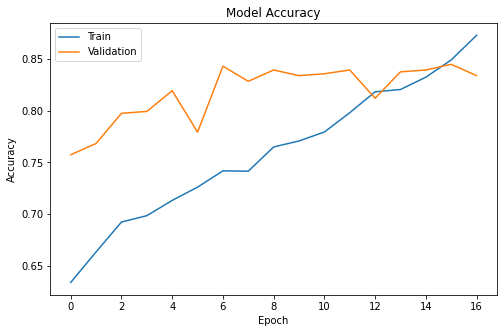

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory = "../input/aptos2019-blindness-detection/test_images",
                                                  x_col="image_path",
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 1928 validated image filenames.


In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model_eff.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1928/1928 [==============================] - 106s 53ms/step


In [ ]:
len(test_labels)

1928

In [ ]:
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": test_labels})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("submission.csv", index=False)

Text(0.5, 1.0, 'Test Samples Per Class')

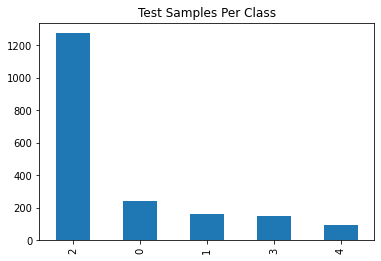

In [ ]:
results['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Samples Per Class')

In [ ]:
!mkdir -p saved_model
model_eff.save('saved_model/my_model')

In [ ]:
# Link to my model weights
# https://drive.google.com/file/d/1I21obcCoqZ47bIMvQt-vK9uUPv5F6NbK/view?usp=sharing

assets	saved_model.pb	variables
